<a href="https://colab.research.google.com/github/YasminDayrell/Trainee-CIS/blob/main/TraineePer%C3%ADodo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


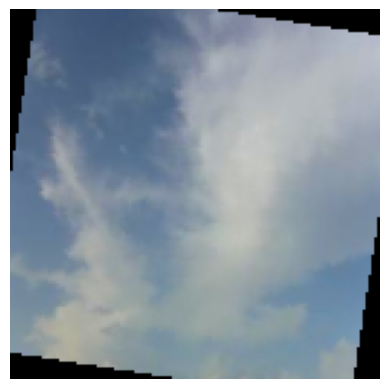

In [9]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os


from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# Transformações para CNN
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    # 50% de chance de espelhar
    transforms.RandomHorizontalFlip(),
    # Rotação aleatória
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # valores comuns em várias redes
                         std=[0.229, 0.224, 0.225])

])

df_train = ImageFolder(    #cada pasta é uma classe
    "/content/drive/MyDrive/clouds/clouds_train",
    transform=train_transforms,
)
df_test = ImageFolder(
    "/content/drive/MyDrive/clouds/clouds_test",
    transform=test_transform,
)


# DataLoaders                                       #embaralha
train_loader = DataLoader(df_train, batch_size=32, shuffle=True)
test_loader = DataLoader(df_test, batch_size=32, shuffle=False)

# Verificar classes
print("Classes:", df_train.classes)

#função do chat apenas para facilitar a visualização
def imshow(img_tensor):
    img = img_tensor.clone().detach()
    img = img.permute(1, 2, 0).numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img * std + mean  # desfaz a normalização
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Exemplo
image, label = next(iter(train_loader))
imshow(image[0])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, num_classes):
        #construtor da classe mãe
        super().__init__()

        #características
        self.features = nn.Sequential(
            #camada 1:    #rgb                                        #saida do mesmo tamanho da entrada
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),            # reduz para 16×64×64

            #camada 2: saida do anterior
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),            # reduz para 32×32×32

            # Camada 3:
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),            # reduz para 64×16×16 -> 16384 características
            nn.Flatten()
        )

        #lógica linear inspirada no exemplo
        self.classifier = nn.Linear(64 * 16 * 16, num_classes)

    def forward(self, x):
        #extrai as caracteristicas
        x = self.features(x)
        #classifica
        x = self.classifier(x)
        return x

In [14]:
%%time
num_classes = len(df_train.classes)

net = Net(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

best_acc = 0.0
patience = 4
trigger_times = 0

num_epochs = 100 #early stopping deve parar antes

for epoch in range(num_epochs):
    net.train()
    running_corrects = 0
    total_train = 0

    #iterar sob os baches
    for images, labels in train_loader:
        optimizer.zero_grad()  #zerar os gradientes anteriores
        outputs = net(images) #passa pelo forward
        loss = criterion(outputs, labels)
        loss.backward()        #calcular os novos gradientes
        optimizer.step()       #atualizar

        _, preds = torch.max(outputs, dim=1)
        running_corrects += torch.sum(preds == labels)
        total_train += images.size(0)

    epoch_acc = running_corrects.double() / total_train

    # Validação
    net.eval()
    val_corrects = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, dim=1)
            val_corrects += torch.sum(preds == labels)
            total_val += images.size(0)

    val_epoch_acc = val_corrects.double() / total_val
    val_epoch_loss = val_loss / total_val

  # Avoid overfitting
    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    print(
        f"Época [{epoch+1}/{num_epochs}] → "
        f"Treino Acc: {epoch_acc:.4f}  |  Val Acc: {val_epoch_acc:.4f}  |  Val Loss: {val_epoch_loss:.4f}"
    )



Época [1/100] → Treino Acc: 0.3017  |  Val Acc: 0.3663  |  Val Loss: 1.4967
Época [2/100] → Treino Acc: 0.4241  |  Val Acc: 0.5206  |  Val Loss: 1.2051
Época [3/100] → Treino Acc: 0.5253  |  Val Acc: 0.4342  |  Val Loss: 1.3702
Época [4/100] → Treino Acc: 0.5359  |  Val Acc: 0.4877  |  Val Loss: 1.3769
Época [5/100] → Treino Acc: 0.5633  |  Val Acc: 0.5535  |  Val Loss: 1.0540
Época [6/100] → Treino Acc: 0.5970  |  Val Acc: 0.6461  |  Val Loss: 0.9184
Época [7/100] → Treino Acc: 0.6350  |  Val Acc: 0.6502  |  Val Loss: 0.9019
Época [8/100] → Treino Acc: 0.6414  |  Val Acc: 0.6584  |  Val Loss: 0.9325
Época [9/100] → Treino Acc: 0.6730  |  Val Acc: 0.6605  |  Val Loss: 0.8648
Época [10/100] → Treino Acc: 0.6245  |  Val Acc: 0.6358  |  Val Loss: 0.9308
Época [11/100] → Treino Acc: 0.6498  |  Val Acc: 0.6193  |  Val Loss: 0.9566
Época [12/100] → Treino Acc: 0.6857  |  Val Acc: 0.6728  |  Val Loss: 0.8548
Época [13/100] → Treino Acc: 0.7131  |  Val Acc: 0.6790  |  Val Loss: 0.8175
Época [1

In [ ]:
%%time
import torchvision.models as models
import torch.nn as nn

num_classes = len(df_train.classes)

# Carregar o modelo pré-treinado (ex: ResNet18)
pretrained_net = models.resnet18(pretrained=True)

# Ajustar a última camada para seu problema
pretrained_net.fc = nn.Linear(pretrained_net.fc.in_features, num_classes)

# (Opcional) congelar camadas, se quiser treinar só a última camada
for param in pretrained_net.parameters():
    param.requires_grad = False
for param in pretrained_net.fc.parameters():
    param.requires_grad = True

# Defina loss e otimizador para este modelo
criterion_pretrained = nn.CrossEntropyLoss()
optimizer_pretrained = torch.optim.Adam(pretrained_net.parameters(), lr=0.001)

best_acc = 00
patience = 5
trigger_times = 0

num_epochs = 100 #early stopping deve parar antes

for epoch in range(num_epochs):
    pretrained_net.train()
    running_corrects = 0
    total_train = 0

    #iterar sob os baches
    for images, labels in train_loader:
        optimizer_pretrained.zero_grad()  #zerar os gradientes anteriores
        outputs = pretrained_net(images) #passa pelo forward
        loss = criterion_pretrained(outputs, labels)
        loss.backward()        #calcular os novos gradientes
        optimizer_pretrained.step()       #atualizar

        _, preds = torch.max(outputs, dim=1)
        running_corrects += torch.sum(preds == labels)
        total_train += images.size(0)

    epoch_acc = running_corrects.double() / total_train

    # Validação
    pretrained_net.eval()
    val_corrects = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = pretrained_net(images)
            loss = criterion_pretrained(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, dim=1)
            val_corrects += torch.sum(preds == labels)
            total_val += images.size(0)

    val_epoch_acc = val_corrects.double() / total_val
    val_epoch_loss = val_loss / total_val

  # Avoid overfitting
    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    print(
        f"Época [{epoch+1}/{num_epochs}] → "
        f"Treino Acc: {epoch_acc:.4f}  |  Val Acc: {val_epoch_acc:.4f}  |  Val Loss: {val_epoch_loss:.4f}"
    )
print("Treinamento concluído.")

Época [1/100] → Treino Acc: 0.3101  |  Val Acc: 0.4136  |  Val Loss: 1.6056
Época [2/100] → Treino Acc: 0.5232  |  Val Acc: 0.5247  |  Val Loss: 1.3744
Época [3/100] → Treino Acc: 0.6139  |  Val Acc: 0.5576  |  Val Loss: 1.2464
Época [4/100] → Treino Acc: 0.6540  |  Val Acc: 0.6111  |  Val Loss: 1.1377
Época [5/100] → Treino Acc: 0.7068  |  Val Acc: 0.6420  |  Val Loss: 1.0772
Época [6/100] → Treino Acc: 0.7743  |  Val Acc: 0.6687  |  Val Loss: 1.0044
Época [7/100] → Treino Acc: 0.7637  |  Val Acc: 0.6934  |  Val Loss: 0.9829
Época [8/100] → Treino Acc: 0.7278  |  Val Acc: 0.7140  |  Val Loss: 0.9310
Época [9/100] → Treino Acc: 0.7869  |  Val Acc: 0.7222  |  Val Loss: 0.8973
Época [10/100] → Treino Acc: 0.7975  |  Val Acc: 0.7284  |  Val Loss: 0.8623
Época [11/100] → Treino Acc: 0.7700  |  Val Acc: 0.7366  |  Val Loss: 0.8727
Época [12/100] → Treino Acc: 0.8228  |  Val Acc: 0.7222  |  Val Loss: 0.8455
Época [13/100] → Treino Acc: 0.7764  |  Val Acc: 0.7469  |  Val Loss: 0.8125
Época [1

O modelo implementado localmente parou na época 20, com a melhor acurácia de 0.7325 , e acurácia final de 0.6893 e finalizando seu processamento em 5min 20s. Já o medelo previamente treinado apresenta um tempo bem maior de processamento (15min 19s), mostrando sua alta complexidade e necessidade de processamentos complexos por parte da máquina. Porém esse processamento refletiou na maior acurácia, de 0.8004, mostrando um aumento porcentual de 10%. Porém dependendo do caso, um aumento de 10% pode não compensar. Nesse contexto a melhora em 10% da acurácia custou um aumento de de 150% no tempo, ou seja, ele mais do que dobrou.

Em relação a regularização, utilizei valores padrão de outros modelos, que já tem vasto uso. Na data augmentation fica nítido que a abordagem depende em parte da análise do autor do código de qual é cabível ou não. Em uma versão anterior eu havia colocado inversão vertical além horizontal, porém as cumulonimbus clouds, por exemplo, estão todas na parte inferior na imagem, e isso talvez poderia confundir o modelo nesse database. Talvez com outro db fizesse mais sentido.